# Optuna Trials For Baseline Model

In [3]:
# Standard library imports
import datetime
import os
from collections import deque
import time

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split

from tqdm import tqdm

if os.path.exists('/workspace/data_2'):
    # Load the dictionary of DataFrames from the pickle
    data_path = '/workspace/data_2/'
else:
    data_path = '../data/'
    
# if torch.cuda.is_available() == False:
#     RuntimeError("GPU detected: False")
#     print("GPU detected: False")
# else:
#     device = torch.device("cuda")
#     print("The GPU is detected.")



### Load Data

In [9]:
dataset_df = pd.read_pickle(data_path + 'full_dataset_df.pkl')

In [ ]:
for i, col in enumerate(dataset_df.columns):
    print(i, col)


0 key_x
1 game
2 tournament_key
3 winner_id
4 loser_id
5 p1_id
6 p2_id
7 p1_score
8 p2_score
9 valid_score
10 best_of
11 location_names
12 bracket_name
13 bracket_order
14 set_order
15 game_data
16 top_8
17 top_8_location_names
18 valid_top_8_bracket
19 top_8_bracket_location_names
20 major
21 key_y
22 start
23 end
24 start_week
25 p1_characters
26 p2_characters
27 p1_consistent
28 p2_consistent
29 matchup_strings
30 end_week
31 players_have_history
32 (p1/p2)_sorted
33 (p1/p2)_was_sorted
34 results_sorted
35 results
36 matchup_1
37 matchup_2
38 matchup_3
39 matchup_4
40 matchup_5
41 matchup_6
42 matchup_7
43 matchup_8
44 matchup_9
45 matchup_10
46 winner
47 p1_default_elo
48 p2_default_elo
49 p1_default_rd
50 p2_default_rd
51 p1_default_updates
52 p2_default_updates
53 start_index
54 start_date
55 p1_fox_count
56 p1_falco_count
57 p1_marth_count
58 p1_sheik_count
59 p1_captainfalcon_count
60 p1_jigglypuff_count
61 p1_peach_count
62 p1_luigi_count
63 p1_samus_count
64 p1_ganondorf_coun

In [13]:
features = dataset_df.columns[36:-1]
target = 'winner'

df = dataset_df.dropna(subset=features)

In [169]:
default_elo_df = df[['winner', 'p1_default_elo', 'p2_default_elo', 'p1_default_rd', 'p2_default_rd', 'p1_default_updates', 'p2_default_updates', 'matchup_1']].copy()
default_elo_df['elo_difference'] = df['p1_default_elo'] - df['p2_default_elo']
default_elo_df = default_elo_df[default_elo_df['elo_difference'] != 0]
default_elo_df['min_rd'] = np.minimum(df['p1_default_rd'], df['p2_default_rd'])
default_elo_df['max_rd'] = np.maximum(df['p1_default_rd'], df['p2_default_rd'])


p2_won = default_elo_df['winner']==0.0
default_elo_df['winning_difference'] = default_elo_df['elo_difference']
default_elo_df.loc[p2_won,'winning_difference'] = default_elo_df.loc[p2_won,'winning_difference'] * -1

In [170]:
default_elo_df.head()

,winner,p1_default_elo,p2_default_elo,p1_default_rd,p2_default_rd,p1_default_updates,p2_default_updates,matchup_1,elo_difference,min_rd,max_rd,winning_difference
0,0.0,1500.000000,1995.568005,350.000000,68.484820,0,10,0.5,-495.568005,68.484820,350.000000,495.568005
1,0.0,1500.000000,1995.568005,350.000000,68.484820,0,10,0.5,-495.568005,68.484820,350.000000,495.568005
2,1.0,1500.000000,2094.642998,350.000000,65.248273,0,10,0.5,-594.642998,65.248273,350.000000,-594.642998
3,1.0,1500.000000,2094.642998,350.000000,65.248273,0,10,0.5,-594.642998,65.248273,350.000000,-594.642998
4,0.0,1960.602597,2105.536004,68.984713,60.842501,11,13,0.5,-144.933407,60.842501,68.984713,144.933407


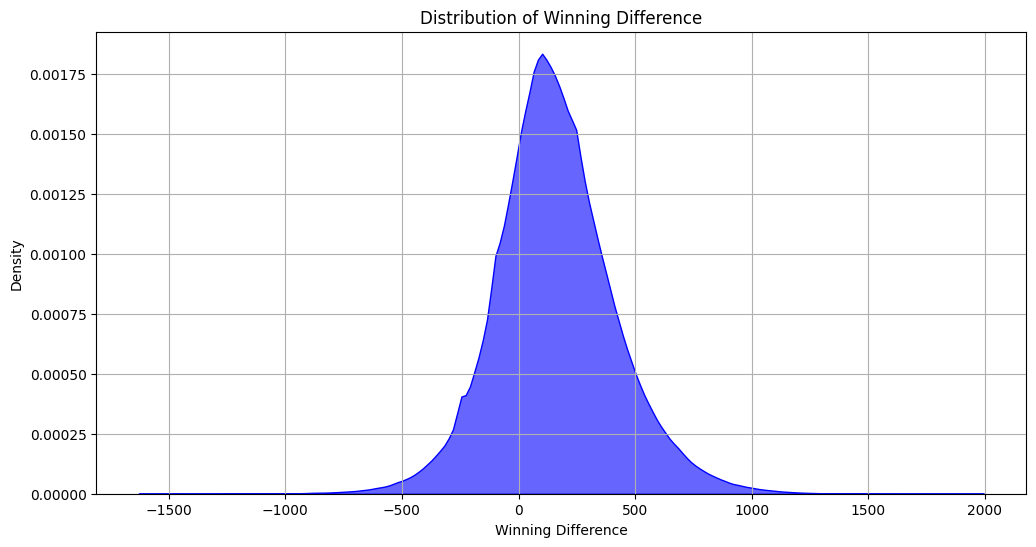

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of winning_difference
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=default_elo_df,
    x='winning_difference',
    fill=True,
    color='blue',
    alpha=0.6
)
plt.title('Distribution of Winning Difference')
plt.xlabel('Winning Difference')
plt.ylabel('Density')
plt.grid()
plt.show()


/tmp/ipykernel_178320/447195042.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_elo_df.groupby('elo_bin')['winner']


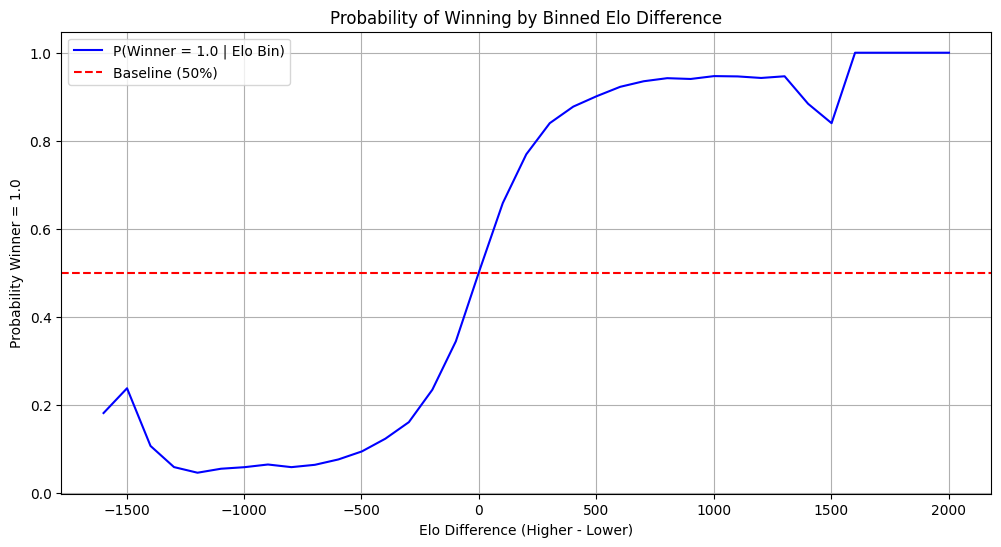

In [178]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define bins for Elo difference
elo_bin_size = 100
default_elo_df['elo_bin'] = pd.cut(
    default_elo_df['elo_difference'], 
    bins=np.arange(default_elo_df['elo_difference'].min(), 
                   default_elo_df['elo_difference'].max() + elo_bin_size, 
                   elo_bin_size)
)

# Calculate probabilities for each bin
binned_probabilities = (
    default_elo_df.groupby('elo_bin')['winner']
    .mean()
    .reset_index()
)

# Add bin midpoints for better x-axis representation
binned_probabilities['elo_bin_midpoint'] = binned_probabilities['elo_bin'].apply(
    lambda x: (x.left + x.right) / 2
)

# Plot the smoothed probabilities
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=binned_probabilities,
    x='elo_bin_midpoint',
    y='winner',
    label='P(Winner = 1.0 | Elo Bin)',
    color='blue'
)
plt.axhline(0.5, color='red', linestyle='--', label='Baseline (50%)')
plt.title('Probability of Winning by Binned Elo Difference')
plt.xlabel('Elo Difference (Higher - Lower)')
plt.ylabel('Probability Winner = 1.0')
plt.legend()
plt.grid()
plt.show()


In [159]:
elo_bin_size = 25
max_elo_bin_value = 500

# Shift the bin boundaries by subtracting half the bin size
default_elo_df['binned_elo_difference'] = (
    np.sign(default_elo_df['elo_difference']) * 
    np.minimum(
        np.ceil((np.abs(default_elo_df['elo_difference']) - elo_bin_size / 2) / elo_bin_size), 
        max_elo_bin_value / elo_bin_size
    ) * elo_bin_size
).astype(np.int16)

rd_bin_size = 100
max_rd_bin_value = 300


default_elo_df['p1_binned_rd'] = (
    np.ceil(default_elo_df['p1_default_rd'] / rd_bin_size) * rd_bin_size
).astype(np.int16)


default_elo_df['p2_binned_rd'] = (
    np.ceil(default_elo_df['p2_default_rd'] / rd_bin_size) * rd_bin_size
).astype(np.int16)

default_elo_df['min_rd'] = np.minimum(default_elo_df['p1_binned_rd'], default_elo_df['p2_binned_rd'])
default_elo_df['max_rd'] = np.maximum(default_elo_df['p1_binned_rd'], default_elo_df['p2_binned_rd'])

In [160]:
default_elo_df.head()

,winner,p1_default_elo,p2_default_elo,p1_default_rd,p2_default_rd,p1_default_updates,p2_default_updates,matchup_1,elo_difference,min_rd,max_rd,binned_elo_difference,binned_min_rd,binned_max_rd,p1_binned_rd,p2_binned_rd
0,0.0,1500.000000,1995.568005,350.000000,68.484820,0,10,0.5,-495.568005,100,400,-500,100,200,400,100
1,0.0,1500.000000,1995.568005,350.000000,68.484820,0,10,0.5,-495.568005,100,400,-500,100,200,400,100
2,1.0,1500.000000,2094.642998,350.000000,65.248273,0,10,0.5,-594.642998,100,400,-500,100,200,400,100
3,1.0,1500.000000,2094.642998,350.000000,65.248273,0,10,0.5,-594.642998,100,400,-500,100,200,400,100
4,0.0,1960.602597,2105.536004,68.984713,60.842501,11,13,0.5,-144.933407,100,100,-150,100,100,100,100


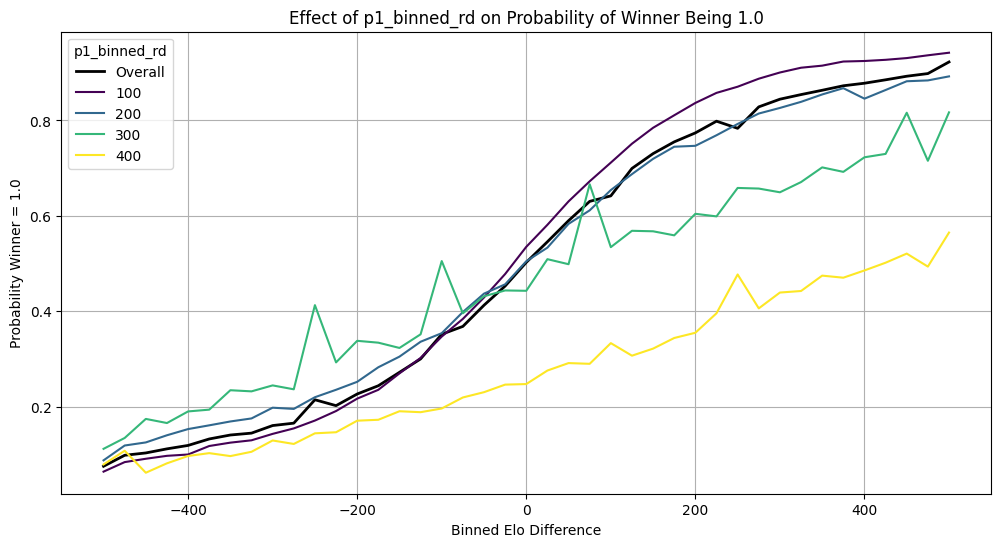

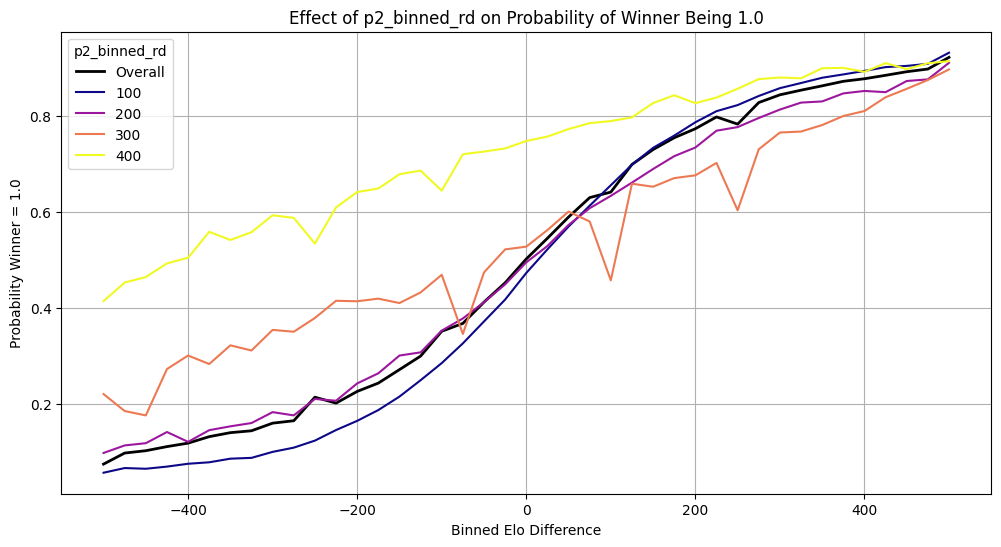

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate overall probability
overall_probabilities = (
    default_elo_df.groupby('binned_elo_difference')['winner']
    .mean()
    .reset_index()
)
overall_probabilities.rename(columns={'winner': 'probability_winner_1'}, inplace=True)

# Calculate probabilities for p1_binned_rd
p1_probabilities = (
    default_elo_df.groupby(['binned_elo_difference', 'p1_binned_rd'])['winner']
    .mean()
    .reset_index()
)
p1_probabilities.rename(columns={'winner': 'probability_winner_1'}, inplace=True)

# Calculate probabilities for p2_binned_rd
p2_probabilities = (
    default_elo_df.groupby(['binned_elo_difference', 'p2_binned_rd'])['winner']
    .mean()
    .reset_index()
)
p2_probabilities.rename(columns={'winner': 'probability_winner_1'}, inplace=True)

# Plot for p1_binned_rd
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=overall_probabilities,
    x='binned_elo_difference',
    y='probability_winner_1',
    label='Overall',
    color='black',
    linewidth=2
)
sns.lineplot(
    data=p1_probabilities,
    x='binned_elo_difference',
    y='probability_winner_1',
    hue='p1_binned_rd',
    palette='viridis'
)
plt.title('Effect of p1_binned_rd on Probability of Winner Being 1.0')
plt.xlabel('Binned Elo Difference')
plt.ylabel('Probability Winner = 1.0')
plt.legend(title='p1_binned_rd')
plt.grid()
plt.show()

# Plot for p2_binned_rd
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=overall_probabilities,
    x='binned_elo_difference',
    y='probability_winner_1',
    label='Overall',
    color='black',
    linewidth=2
)
sns.lineplot(
    data=p2_probabilities,
    x='binned_elo_difference',
    y='probability_winner_1',
    hue='p2_binned_rd',
    palette='plasma'
)
plt.title('Effect of p2_binned_rd on Probability of Winner Being 1.0')
plt.xlabel('Binned Elo Difference')
plt.ylabel('Probability Winner = 1.0')
plt.legend(title='p2_binned_rd')
plt.grid()
plt.show()


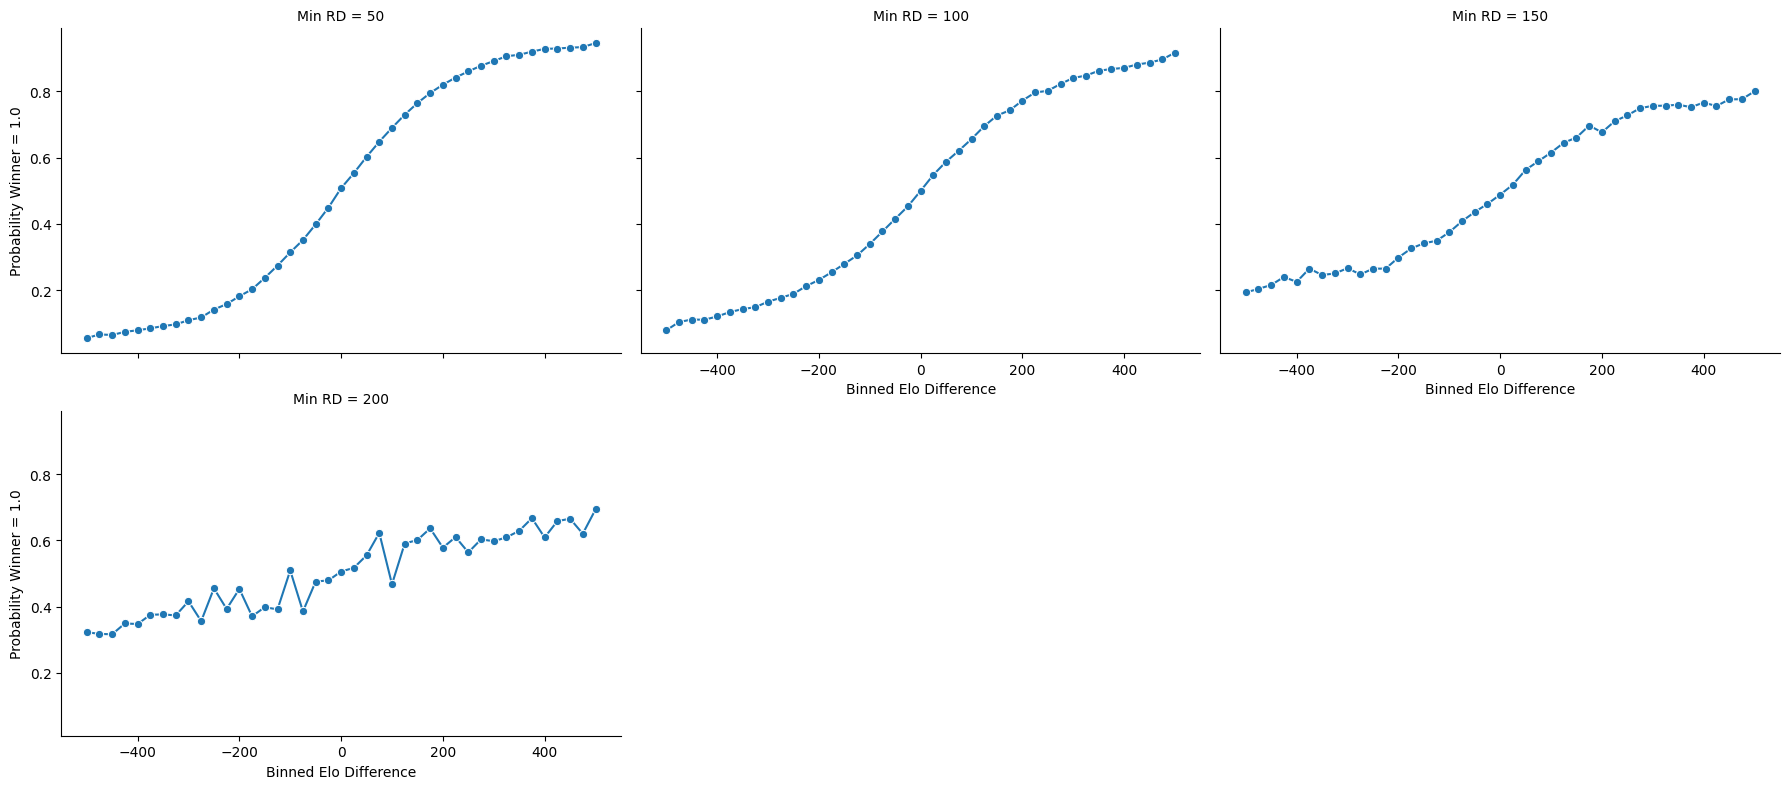

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the probability of the winner being 1.0 grouped by binned_elo_difference and binned_min_rd
probabilities = (
    default_elo_df.groupby(['binned_elo_difference', 'binned_min_rd'])['winner']
    .mean()
    .reset_index()
)

# Rename for clarity
probabilities.rename(columns={'winner': 'probability_winner_1'}, inplace=True)

# Create a Seaborn plot
g = sns.FacetGrid(
    probabilities,
    col="binned_min_rd",
    col_wrap=3,  # Adjust the number of columns for the grid
    sharey=True,
    height=4,
    aspect=1.5
)
g.map(sns.lineplot, 'binned_elo_difference', 'probability_winner_1', marker='o')

# Add titles and labels
g.set_axis_labels('Binned Elo Difference', 'Probability Winner = 1.0')
g.set_titles('Min RD = {col_name}')
g.tight_layout()

plt.show()


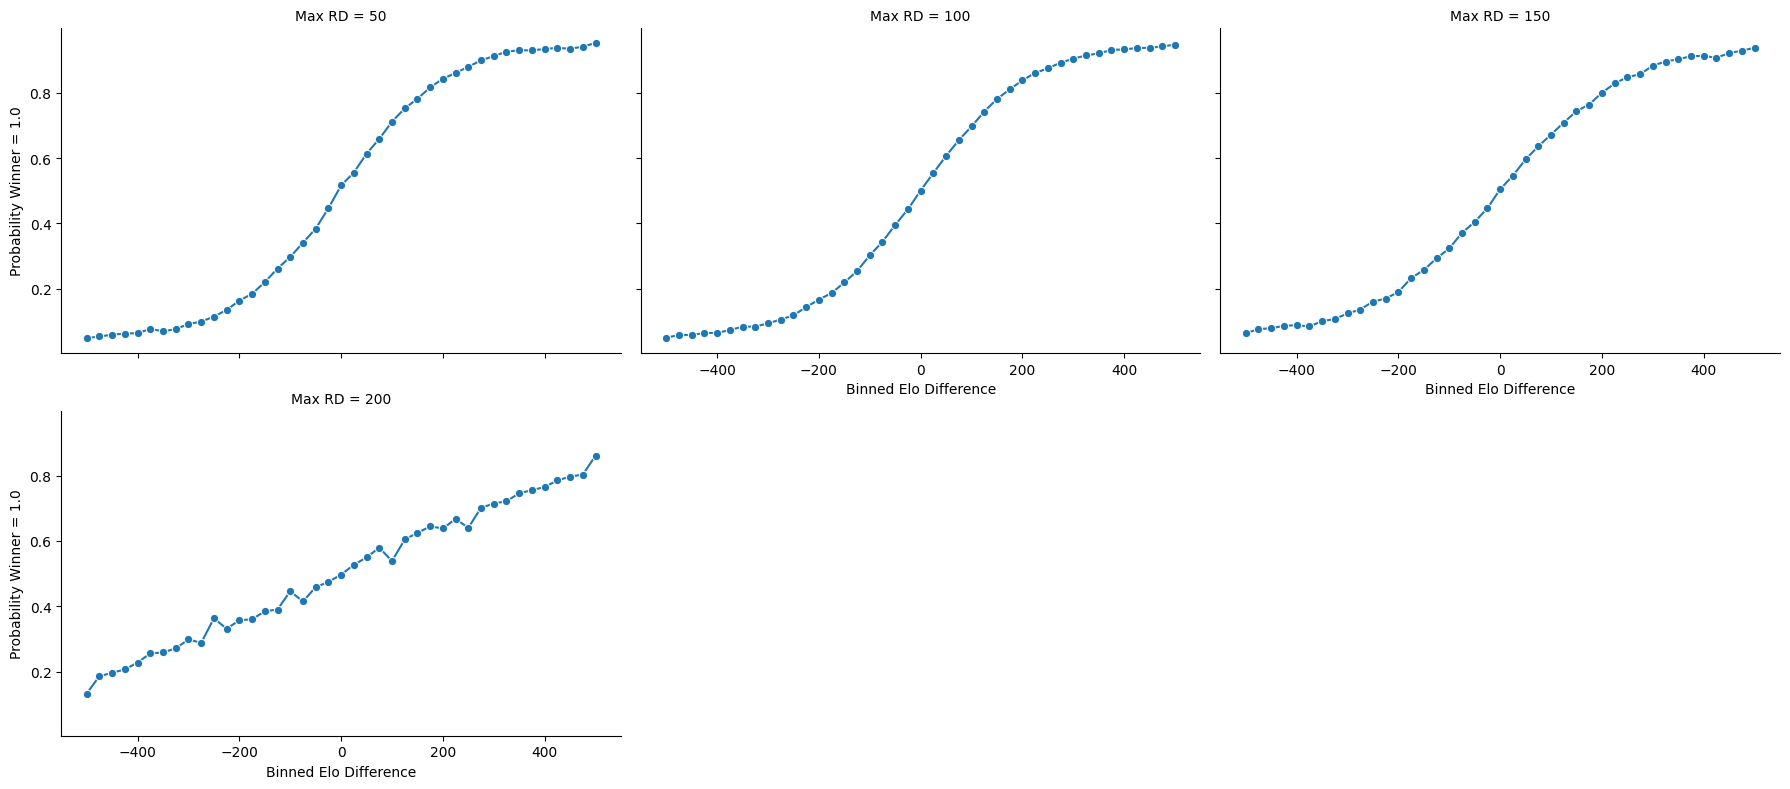

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the probability of the winner being 1.0 grouped by binned_elo_difference and binned_min_rd
probabilities = (
    default_elo_df.groupby(['binned_elo_difference', 'binned_max_rd'])['winner']
    .mean()
    .reset_index()
)

# Rename for clarity
probabilities.rename(columns={'winner': 'probability_winner_1'}, inplace=True)

# Create a Seaborn plot
g = sns.FacetGrid(
    probabilities,
    col="binned_max_rd",
    col_wrap=3,  # Adjust the number of columns for the grid
    sharey=True,
    height=4,
    aspect=1.5
)
g.map(sns.lineplot, 'binned_elo_difference', 'probability_winner_1', marker='o')

# Add titles and labels
g.set_axis_labels('Binned Elo Difference', 'Probability Winner = 1.0')
g.set_titles('Max RD = {col_name}')
g.tight_layout()

plt.show()

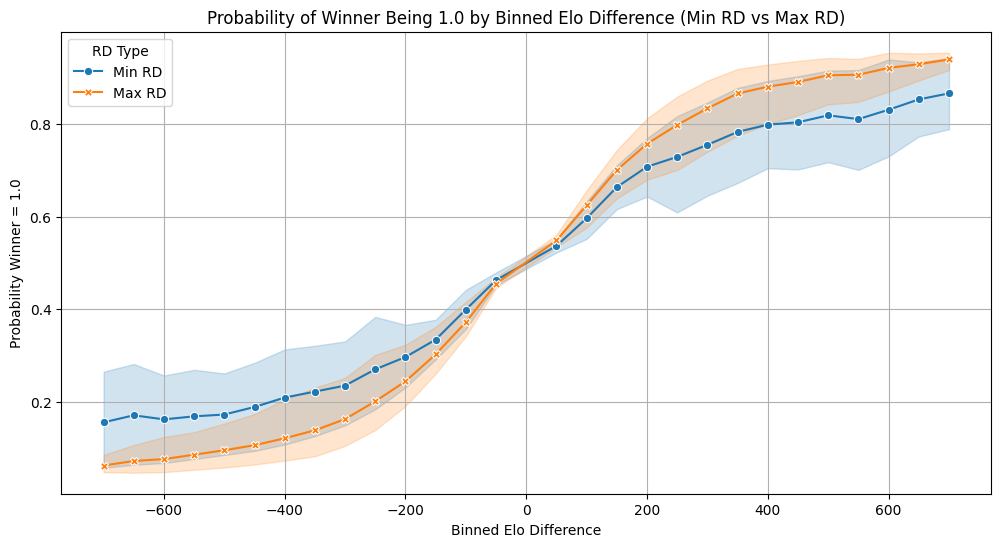

In [142]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the probabilities for both Min RD and Max RD
min_rd_probabilities = (
    default_elo_df.groupby(['binned_elo_difference', 'binned_min_rd'])['winner']
    .mean()
    .reset_index()
)
min_rd_probabilities['RD Type'] = 'Min RD'  # Add a column to distinguish Min RD

max_rd_probabilities = (
    default_elo_df.groupby(['binned_elo_difference', 'binned_max_rd'])['winner']
    .mean()
    .reset_index()
)
max_rd_probabilities['RD Type'] = 'Max RD'  # Add a column to distinguish Max RD

# Rename for clarity
min_rd_probabilities.rename(columns={'winner': 'probability_winner_1'}, inplace=True)
max_rd_probabilities.rename(columns={'winner': 'probability_winner_1'}, inplace=True)

# Combine the two DataFrames
combined_probabilities = pd.concat([min_rd_probabilities, max_rd_probabilities], ignore_index=True)

# Create a Seaborn FacetGrid plot with RD Type as hue
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_probabilities,
    x='binned_elo_difference',
    y='probability_winner_1',
    hue='RD Type',
    style='RD Type',
    markers=True,
    dashes=False
)

# Add titles and labels
plt.title('Probability of Winner Being 1.0 by Binned Elo Difference (Min RD vs Max RD)')
plt.xlabel('Binned Elo Difference')
plt.ylabel('Probability Winner = 1.0')
plt.legend(title='RD Type')
plt.grid()

# Show the plot
plt.show()


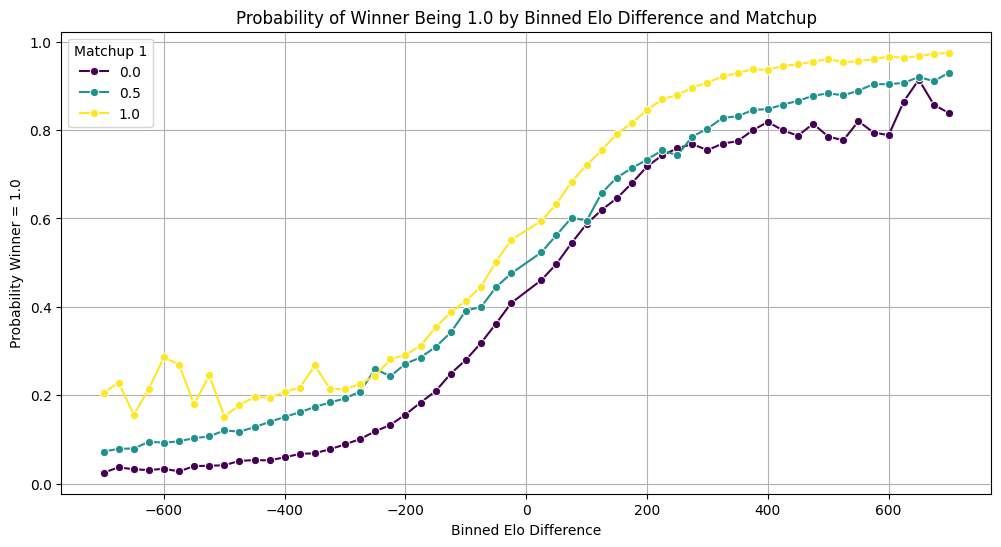

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the `matchup_1` column exists in your DataFrame; adjust this as needed
# For demonstration, replace "matchup_1" with the actual column name or create one if missing

# Calculate the probabilities for each combination of binned_elo_difference and matchup_1
probabilities = (
    default_elo_df.groupby(['binned_elo_difference', 'matchup_1'])['winner']
    .mean()
    .reset_index()
)

# Rename for clarity
probabilities.rename(columns={'winner': 'probability_winner_1'}, inplace=True)

# Plot the results with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=probabilities,
    x='binned_elo_difference',
    y='probability_winner_1',
    hue='matchup_1',
    marker='o',
    palette='viridis'
)

# Add titles and labels
plt.title('Probability of Winner Being 1.0 by Binned Elo Difference and Matchup')
plt.xlabel('Binned Elo Difference')
plt.ylabel('Probability Winner = 1.0')
plt.legend(title='Matchup 1')
plt.grid()

# Show the plot
plt.show()
